# Neural Style Transfer: An Implementation Using VGG19

Submitted By

Sheheryar Sohail 03-134211-040

Murtaza Anwaar   03-134211-032

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
pip install tensorflow numpy matplotlib

In [ ]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img, target_size=(400, 400))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

content_path = '/content/lordPuneet.jpg'
style_path = '/content/kingCharles.jpeg'
content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)


In [ ]:
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    model_outputs = content_outputs + style_outputs
    return Model(vgg.input, model_outputs)

model = get_model()


In [ ]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)
def get_style_loss(base_style, gram_target):
    # Verify that the shape tuple has three elements
    tf.debugging.assert_equal(tf.size(tf.shape(base_style)), 3)

    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    model_outputs = model(init_image)
    content_output_features = model_outputs[:len(content_features)]
    style_output_features = model_outputs[len(content_features):]

    content_score = 0
    style_score = 0

    weight_content, weight_style = loss_weights

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += get_content_loss(comb_content, target_content)

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += get_style_loss(comb_style[:, :, :, 0], target_style)

    content_score *= weight_content
    style_score *= weight_style

    loss = content_score + style_score
    return loss

In [ ]:
def get_style_loss(base_style, gram_target):
    # Verify that the shape tuple has three elements
    tf.debugging.assert_equal(tf.size(tf.shape(base_style)), 3)

    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    content_features = model(content_image)[:1]
    style_features = model(style_image)[1:]
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    iter_count = 1

    best_loss, best_img = float('inf'), None

    loss_weights = (content_weight, style_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, content_score, style_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, -103.939, 255.0 - 103.939)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % 100 == 0:
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}'.format(loss, style_score, content_score))

    return best_img, best_loss

best_img, best_loss = run_style_transfer(content_path, style_path)
plt.imshow(best_img)
plt.show()


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [400,400] vs. [64,64] [Op:Sub] name: 

Iteration: 0
Total loss: 1.6228e+09, style loss: 1.6228e+09, content loss: 0.0000e+00
Iteration: 100
Total loss: 4.5319e+07, style loss: 4.1113e+07, content loss: 4.2060e+06
Iteration: 200
Total loss: 1.9441e+07, style loss: 1.5813e+07, content loss: 3.6275e+06
Iteration: 300
Total loss: 1.1622e+07, style loss: 8.4304e+06, content loss: 3.1918e+06
Iteration: 400
Total loss: 8.2405e+06, style loss: 5.4395e+06, content loss: 2.8010e+06
Iteration: 500
Total loss: 6.5106e+06, style loss: 3.9795e+06, content loss: 2.5311e+06
Iteration: 600
Total loss: 5.5215e+06, style loss: 3.1697e+06, content loss: 2.3518e+06
Iteration: 700
Total loss: 4.9134e+06, style loss: 2.6886e+06, content loss: 2.2248e+06
Iteration: 800
Total loss: 4.4975e+06, style loss: 2.3702e+06, content loss: 2.1273e+06
Iteration: 900
Total loss: 4.1934e+06, style loss: 2.1377e+06, content loss: 2.0556e+06


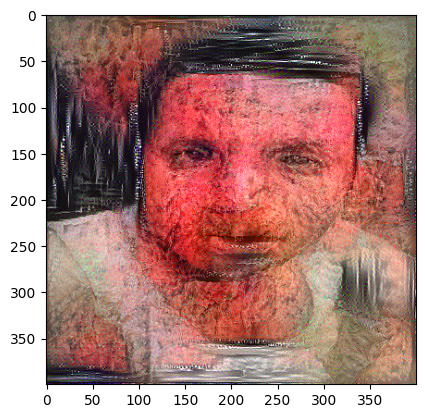

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_img(path_to_img):
    img = load_img(path_to_img, target_size=(400, 400))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    model_outputs = content_outputs + style_outputs
    return Model(vgg.input, model_outputs)

def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    model_outputs = model(init_image)
    content_output_features = model_outputs[:len(content_features)]
    style_output_features = model_outputs[len(content_features):]

    content_score = 0
    style_score = 0

    weight_content, weight_style = loss_weights

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += get_content_loss(comb_content, target_content)

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += get_style_loss(comb_style, target_style)

    content_score *= weight_content
    style_score *= weight_style

    loss = content_score + style_score
    return loss, content_score, style_score

def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    content_features = model(content_image)[:1]
    style_features = model(style_image)[1:]
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    iter_count = 1

    best_loss, best_img = float('inf'), None

    loss_weights = (content_weight, style_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, content_score, style_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, -103.939, 255.0 - 103.939)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % 100 == 0:
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}'.format(loss, style_score, content_score))

    return best_img, best_loss

content_path = '/content/lordPuneet.jpg'
style_path = '/content/kingCharles.jpeg'
best_img, best_loss = run_style_transfer(content_path, style_path)
plt.imshow(best_img)
plt.show()
